In [1]:
import os

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate, Input
from transformers import BertTokenizer, AlbertTokenizer, TFBertModel, TFAlbertModel
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score,accuracy_score
from sklearn.preprocessing import LabelEncoder


In [3]:


# Load your data (replace 'your_data.csv' with your actual file path)
df = pd.read_csv('/content/drive/MyDrive/Movie Reccomendation/new_movies.csv')  # Update with your dataset path
df=df.sample(frac=0.1)
df.reset_index(drop=True,inplace=True)

# Preprocess text data (lowercase, remove punctuation, etc.)
df['review'] = df['review'].str.lower().str.replace('[^a-zA-Z0-9\s]', '')

# Separate features and target
reviews = df['review'].tolist()
# ratings = df['rating'].tolist()
label_encoder = LabelEncoder()

# Fit and transform the categorical column
ratings = label_encoder.fit_transform(df['movieid']).tolist()

# Define maximum review length
max_length = 200  # Adjust this based on your data

# Tokenization for ALBERT and BERT models (load appropriate tokenizers)
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Adjust model name if needed

# Tokenize reviews for both models
albert_tokens = albert_tokenizer(reviews, padding='max_length', truncation=True, max_length=max_length)
bert_tokens = bert_tokenizer(reviews, padding='max_length', truncation=True, max_length=max_length)

# Convert tokenized data to numerical sequences
albert_sequences = pad_sequences(albert_tokens['input_ids'], maxlen=max_length)
bert_sequences = pad_sequences(bert_tokens['input_ids'], maxlen=max_length)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 

The secret `HF_TOKEN` does not exist in your Colab secrets.

To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.

You will be able to reuse this secret in all of your notebooks.

Please note that authentication is recommended but still optional to access public models or datasets.

  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
df

,review,sentiment,user,rating,movieid
0,"i sell the dead is a big, sloppy horror comedy...",positive,6WRKB,1,49a3852d69
1,how did mike hammer live - in a penthouse with...,negative,NZWZQ,3,1d2d0cfbc1
2,this movie has successfully proved what we all...,negative,JLGSQ,4,039e2c730b
3,"i grew up in the 90s; therefore, you must unde...",negative,NHTJN,7,7c47f1fc1a
4,"first and foremost, zorie barber (zeke), might...",negative,ZQURQ,6,7c4f782751
...,...,...,...,...,...
4995,like most of the festivals entries hamiltons m...,negative,JXS9Z,2,e6d4d4108e
4996,this was amongst the worst films i have ever e...,negative,NT6EA,4,7a459e352b
4997,unfortunately the only spoiler in this review ...,negative,TWICV,8,574bde1042
4998,i first saw this movie at a premiere-party in ...,positive,GVEAX,6,ab4c1f2f8b


In [5]:
from tensorflow.keras.layers import Input, Embedding, Dense, concatenate, LSTM
unique=np.unique(df['movieid']).shape[0]
# Define separate inputs for ALBERT and BERT sequences
albert_input = Input(shape=(max_length,))
bert_input = Input(shape=(max_length,))

# Embedding layer
albert_embedding = Embedding(albert_tokenizer.vocab_size, 128)(albert_input)  # Adjust embedding size
bert_embedding = Embedding(bert_tokenizer.vocab_size, 128)(bert_input)  # Adjust embedding size



# LSTM layer for ALBERT and BERT sequences (consider using Bi-LSTM for better context capture)
albert_lstm = LSTM(64)(albert_embedding)
bert_lstm = LSTM(64)(bert_embedding)

# Concatenate outputs from ALBERT and BERT LSTMs
merged = concatenate([albert_lstm, bert_lstm])

# Dense layers for prediction
dense1 = Dense(32, activation='relu')(merged)
output = Dense(unique, activation='softmax')(dense1)

# Define the model
model = tf.keras.Model(inputs=[albert_input, bert_input], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True), metrics=['accuracy'])
model.summary()


Model: "model"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 200)]                0         []                            

                                                                                                  

 input_2 (InputLayer)        [(None, 200)]                0         []                            

                                                                                                  

 embedding (Embedding)       (None, 200, 128)             3840000   ['input_1[0][0]']             

                                                                                                  

 embedding_1 (Embedding)     (None, 200, 128)             3906816   ['input_2[0][0]']             

                                                                                   

In [6]:
albert_sequences.shape

(5000, 200)

In [7]:
bert_sequences.shape

(5000, 200)

In [8]:
df

,review,sentiment,user,rating,movieid
0,"i sell the dead is a big, sloppy horror comedy...",positive,6WRKB,1,49a3852d69
1,how did mike hammer live - in a penthouse with...,negative,NZWZQ,3,1d2d0cfbc1
2,this movie has successfully proved what we all...,negative,JLGSQ,4,039e2c730b
3,"i grew up in the 90s; therefore, you must unde...",negative,NHTJN,7,7c47f1fc1a
4,"first and foremost, zorie barber (zeke), might...",negative,ZQURQ,6,7c4f782751
...,...,...,...,...,...
4995,like most of the festivals entries hamiltons m...,negative,JXS9Z,2,e6d4d4108e
4996,this was amongst the worst films i have ever e...,negative,NT6EA,4,7a459e352b
4997,unfortunately the only spoiler in this review ...,negative,TWICV,8,574bde1042
4998,i first saw this movie at a premiere-party in ...,positive,GVEAX,6,ab4c1f2f8b


In [10]:

# Sample data


# Create LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the categorical column
encoded_data = label_encoder.fit_transform(df['movieid'])

# Print the encoded data
print(encoded_data)


[1398  555   73 ... 1677 3368  943]


In [12]:
ll

array([1398,  555,   73, ..., 1677, 3368,  943])

In [13]:
ll=np.array(encoded_data)
encoded_data = keras.utils.to_categorical(ll,unique)

In [14]:
encoded_data.shape

(5000, 4994)

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert ratings to numpy array if it's not already
movieid = np.array(encoded_data)

# Split albert_sequences and bert_sequences separately
X_train_albert, X_test_albert, X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    albert_sequences, bert_sequences, movieid, test_size=0.2, random_state=42)
# Now, you have separate train and test sets for albert_sequences and bert_sequences
# You can then pass them separately to the model.fit method
X_test_albert.shape,X_test_bert.shape,y_test.shape

((1000, 200), (1000, 200), (1000, 4994))

In [16]:
pred_albert,pred_bert,pred_y=X_test_albert[int(len(X_test_albert)/10):],X_test_bert[int(len(X_test_albert)/10):],y_test[int(len(X_test_albert)/10):]
pred_albert.shape,pred_bert.shape,pred_y.shape

((900, 200), (900, 200), (900, 4994))

In [17]:
pred_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
history=model.fit([X_train_albert, X_train_bert], y_train, epochs=10, batch_size=32,validation_split=0.2)  # Adjust epochs and batch size


Epoch 1/10

100/100 [==============================] - 50s 468ms/step - loss: 8.5161 - accuracy: 0.0000e+00 - val_loss: 8.5161 - val_accuracy: 0.0000e+00

Epoch 2/10

100/100 [==============================] - 45s 450ms/step - loss: 8.5160 - accuracy: 0.0000e+00 - val_loss: 8.5164 - val_accuracy: 0.0000e+00

Epoch 3/10

100/100 [==============================] - 44s 443ms/step - loss: 8.5158 - accuracy: 0.0000e+00 - val_loss: 8.5166 - val_accuracy: 0.0000e+00

Epoch 4/10

100/100 [==============================] - 42s 417ms/step - loss: 8.5157 - accuracy: 0.0000e+00 - val_loss: 8.5168 - val_accuracy: 0.0000e+00

Epoch 5/10

100/100 [==============================] - 41s 411ms/step - loss: 8.5156 - accuracy: 3.1250e-04 - val_loss: 8.5170 - val_accuracy: 0.0000e+00

Epoch 6/10

100/100 [==============================] - 49s 491ms/step - loss: 8.5154 - accuracy: 6.2500e-04 - val_loss: 8.5173 - val_accuracy: 0.0000e+00

Epoch 7/10

100/100 [==============================] - 42s 423ms/step 

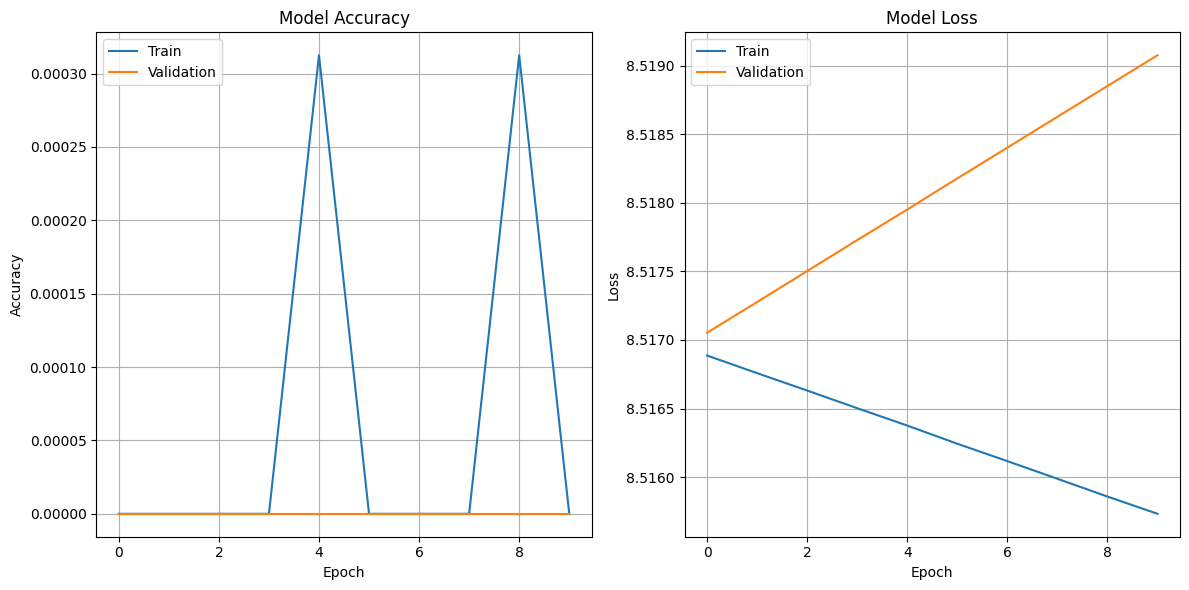

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on test data
# loss, mae = model.evaluate([X_test_albert, X_test_bert], y_test)
model.evaluate([X_test_albert, X_test_bert], y_test)
# Print evaluation metrics
# print('Loss:', loss)
# print('MAE:', mae)

# Function to predict rating for a user and movie based on their review


32/32 [==============================] - 3s 65ms/step - loss: 8.5189 - accuracy: 0.0000e+00


[8.518939018249512, 0.0]

In [ ]:
y_pred_prob= model.predict([pred_albert,pred_bert])

29/29 [==============================] - 4s 101ms/step


In [ ]:
y_pred=np.argmax(y_pred_prob,axis=1)

In [ ]:
y_pred.shape

(900,)

In [ ]:
np.argmax(pred_y,axis=1).shape

(900,)

In [ ]:
accuracy_score(np.argmax(pred_y,axis=1), y_pred)

0.0

In [ ]:
f1 = f1_score(np.argmax(pred_y,axis=1), y_pred, average='weighted')


In [ ]:
pred_y.shape

(900, 4998)

In [ ]:
y_pred_prob.shape

(900, 4998)

In [ ]:
report = classification_report(np.argmax(pred_y,axis=1), y_pred)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classific

In [ ]:
report

'              precision    recall  f1-score   support\n\n           2       0.00      0.00      0.00       1.0\n           4       0.00      0.00      0.00       1.0\n          13       0.00      0.00      0.00       1.0\n          14       0.00      0.00      0.00       1.0\n          19       0.00      0.00      0.00       1.0\n          21       0.00      0.00      0.00       1.0\n          25       0.00      0.00      0.00       1.0\n          26       0.00      0.00      0.00       1.0\n          32       0.00      0.00      0.00       1.0\n          39       0.00      0.00      0.00       1.0\n          46       0.00      0.00      0.00       1.0\n          48       0.00      0.00      0.00       1.0\n          51       0.00      0.00      0.00       1.0\n          54       0.00      0.00      0.00       1.0\n          73       0.00      0.00      0.00       1.0\n          85       0.00      0.00      0.00       1.0\n          88       0.00      0.00      0.00       1.0\n       

In [ ]:
pred_y.shape

(900, 4998)

In [ ]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_pred_prob

array([[0.49986523, 0.50082844, 0.49996963, ..., 0.5004697 , 0.5005715 ,
        0.50013137],
       [0.5000126 , 0.5006181 , 0.4998992 , ..., 0.500696  , 0.49988174,
        0.500125  ],
       [0.49986523, 0.50082844, 0.49996963, ..., 0.5004697 , 0.5005715 ,
        0.50013137],
       ...,
       [0.49986506, 0.50082886, 0.49996972, ..., 0.5004695 , 0.50057113,
        0.5001316 ],
       [0.4998953 , 0.5008798 , 0.49999925, ..., 0.5004372 , 0.5005691 ,
        0.50014657],
       [0.5001688 , 0.49993888, 0.4994244 , ..., 0.5006452 , 0.50025636,
        0.500341  ]], dtype=float32)

In [ ]:
pred_y.shape

(900, 4998)

In [ ]:
y_pred_prob.shape

(900, 4998)

In [ ]:
from sklearn.metrics import average_precision_score

# Compute average precision score for multi-label classification
average_precision = average_precision_score(pred_y, y_pred_prob, average='weighted')
print(f'Average Precision Score (Multi-label): {average_precision}')


Streaming output truncated to the last 5000 lines.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/skl

Average Precision Score (Multi-label): 0.0073692376298748015


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positi

In [ ]:
# # Inverse transform to get string categories back
original_data = label_encoder.inverse_transform(y_pred)

# Print the original string categories
print(original_data)

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Load your data
df = pd.read_csv('/content/drive/MyDrive/Movie Reccomendation/new_movies.csv')
df = df.sample(frac=0.1).reset_index(drop=True)

# Preprocess text data
df['review'] = df['review'].str.lower().str.replace('[^a-zA-Z0-9\s]', '')

# Separate features and target
reviews = df['review'].tolist()
label_encoder = LabelEncoder()
ratings = label_encoder.fit_transform(df['movieid']).tolist()

# Tokenization and padding
max_length = 200
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
albert_tokens = albert_tokenizer(reviews, padding='max_length', truncation=True, max_length=max_length)
bert_tokens = bert_tokenizer(reviews, padding='max_length', truncation=True, max_length=max_length)
albert_sequences = pad_sequences(albert_tokens['input_ids'], maxlen=max_length)
bert_sequences = pad_sequences(bert_tokens['input_ids'], maxlen=max_length)

# Define model inputs
albert_input = Input(shape=(max_length,))
bert_input = Input(shape=(max_length,))

# Embedding layer
embedding_size = 128
albert_embedding = Embedding(albert_tokenizer.vocab_size, embedding_size)(albert_input)
bert_embedding = Embedding(bert_tokenizer.vocab_size, embedding_size)(bert_input)

# LSTM layer
lstm_units = 64
albert_lstm = LSTM(lstm_units)(albert_embedding)
bert_lstm = LSTM(lstm_units)(bert_embedding)

# Concatenate LSTM outputs
merged = concatenate([albert_lstm, bert_lstm])

# Dense layers
dense_units = 32
output_classes = len(np.unique(df['movieid']))
dense1 = Dense(dense_units, activation='relu')(merged)
output = Dense(output_classes, activation='softmax')(dense1)

# Define the model
model = Model(inputs=[albert_input, bert_input], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Convert ratings to one-hot encoded format
encoded_ratings = to_categorical(ratings, num_classes=output_classes)

# Train-test split
X_train_albert, X_test_albert, X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    albert_sequences, bert_sequences, encoded_ratings, test_size=0.2, random_state=42)

# Fit the model
history = model.fit([X_train_albert, X_train_bert], y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10

100/100 [==============================] - 60s 562ms/step - loss: 8.5289 - accuracy: 0.0000e+00 - val_loss: 8.5516 - val_accuracy: 0.0000e+00

Epoch 2/10

100/100 [==============================] - 51s 513ms/step - loss: 8.4749 - accuracy: 0.0000e+00 - val_loss: 8.8398 - val_accuracy: 0.0000e+00

Epoch 3/10

100/100 [==============================] - 48s 480ms/step - loss: 8.3208 - accuracy: 0.0000e+00 - val_loss: 9.0937 - val_accuracy: 0.0000e+00

Epoch 4/10

100/100 [==============================] - 45s 449ms/step - loss: 7.8829 - accuracy: 0.0000e+00 - val_loss: 10.0641 - val_accuracy: 0.0000e+00

Epoch 5/10

100/100 [==============================] - 43s 436ms/step - loss: 7.5316 - accuracy: 3.1250e-04 - val_loss: 10.8620 - val_accuracy: 0.0000e+00

Epoch 6/10

100/100 [==============================] - 43s 429ms/step - loss: 7.2089 - accuracy: 9.3750e-04 - val_loss: 11.6217 - val_accuracy: 0.0000e+00

Epoch 7/10

100/100 [==============================] - 43s 430ms/st

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import gensim.downloader as api

# Load your data
df = pd.read_csv('/content/drive/MyDrive/Movie Reccomendation/new_movies.csv')
df = df.sample(frac=0.1).reset_index(drop=True)

# Preprocess text data
df['review'] = df['review'].str.lower().str.replace('[^a-zA-Z0-9\s]', '')

# Separate features and target
reviews = df['review'].tolist()
label_encoder = LabelEncoder()
ratings = label_encoder.fit_transform(df['movieid']).tolist()

# Tokenization and padding
max_length = 200
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
albert_tokens = albert_tokenizer(reviews, padding='max_length', truncation=True, max_length=max_length)
bert_tokens = bert_tokenizer(reviews, padding='max_length', truncation=True, max_length=max_length)
albert_sequences = pad_sequences(albert_tokens['input_ids'], maxlen=max_length)
bert_sequences = pad_sequences(bert_tokens['input_ids'], maxlen=max_length)

# Load GloVe embeddings
glove_vectors = api.load('glove-wiki-gigaword-300')

# Create embedding matrix
embedding_matrix = np.zeros((len(albert_tokenizer.word_index) + 1, glove_vectors.vectors.shape[1]))
for word, i in albert_tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]

# Define model inputs
albert_input = Input(shape=(max_length,))
bert_input = Input(shape=(max_length,))

# Embedding layer with GloVe embeddings
embedding_size = glove_vectors.vectors.shape[1]
albert_embedding = Embedding(len(albert_tokenizer.word_index) + 1, embedding_size, weights=[embedding_matrix],
                             input_length=max_length, trainable=False)(albert_input)
bert_embedding = Embedding(len(albert_tokenizer.word_index) + 1, embedding_size, weights=[embedding_matrix],
                           input_length=max_length, trainable=False)(bert_input)

# Bidirectional LSTM layer
lstm_units = 128
albert_lstm = Bidirectional(LSTM(lstm_units))(albert_embedding)
bert_lstm = Bidirectional(LSTM(lstm_units))(bert_embedding)

# Concatenate LSTM outputs
merged = concatenate([albert_lstm, bert_lstm])

# Dense layers
dense_units = 64
output_classes = len(np.unique(df['movieid']))
dense1 = Dense(dense_units, activation='relu')(merged)
output = Dense(output_classes, activation='softmax')(dense1)

# Define the model
model = Model(inputs=[albert_input, bert_input], outputs=output)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Convert ratings to numpy array
encoded_ratings = np.array(ratings)

# Train-test split
X_train_albert, X_test_albert, X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    albert_sequences, bert_sequences, encoded_ratings, test_size=0.2, random_state=42)

# Fit the model
history = model.fit([X_train_albert, X_train_bert], y_train, epochs=20, batch_size=64, validation_split=0.2)


[==================================================] 100.0% 376.1/376.1MB downloaded


AttributeError: 'AlbertTokenizer' object has no attribute 'word_index'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import gensim.downloader as api

# Load your data
df = pd.read_csv('/kaggle/input/movie-recommendation-dataset/new_movies.csv')
df = df.sample(frac=0.1).reset_index(drop=True)

# Preprocess text data
df['review'] = df['review'].str.lower().str.replace('[^a-zA-Z0-9\s]', '')

# Separate features and target
reviews = df['review'].tolist()
label_encoder = LabelEncoder()
ratings = label_encoder.fit_transform(df['movieid']).tolist()

# Tokenization and padding
max_length = 200
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
albert_tokens = albert_tokenizer(reviews, padding='max_length', truncation=True, max_length=max_length)
bert_tokens = bert_tokenizer(reviews, padding='max_length', truncation=True, max_length=max_length)
albert_sequences = pad_sequences(albert_tokens['input_ids'], maxlen=max_length)
bert_sequences = pad_sequences(bert_tokens['input_ids'], maxlen=max_length)

# Load GloVe embeddings
glove_vectors = api.load('glove-wiki-gigaword-300')

# Create embedding matrix
albert_vocab = albert_tokenizer.get_vocab()
embedding_matrix = np.zeros((len(albert_vocab) + 1, glove_vectors.vectors.shape[1]))
for word, i in albert_vocab.items():
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]

# Define model inputs
albert_input = Input(shape=(max_length,))
bert_input = Input(shape=(max_length,))

# Embedding layer with GloVe embeddings
embedding_size = glove_vectors.vectors.shape[1]
albert_embedding = Embedding(len(albert_vocab) + 1, embedding_size, weights=[embedding_matrix],
                             input_length=max_length, trainable=False)(albert_input)
bert_embedding = Embedding(len(albert_vocab) + 1, embedding_size, weights=[embedding_matrix],
                           input_length=max_length, trainable=False)(bert_input)

# Bidirectional LSTM layer
lstm_units = 128
albert_lstm = Bidirectional(LSTM(lstm_units))(albert_embedding)
bert_lstm = Bidirectional(LSTM(lstm_units))(bert_embedding)

# Concatenate LSTM outputs
merged = concatenate([albert_lstm, bert_lstm])

# Dense layers
dense_units = 64
output_classes = len(np.unique(df['movieid']))
dense1 = Dense(dense_units, activation='relu')(merged)
output = Dense(output_classes, activation='softmax')(dense1)

# Define the model
model = Model(inputs=[albert_input, bert_input], outputs=output)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Convert ratings to numpy array
encoded_ratings = np.array(ratings)

# Train-test split
X_train_albert, X_test_albert, X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    albert_sequences, bert_sequences, encoded_ratings, test_size=0.2, random_state=42)

# Fit the model
history = model.fit([X_train_albert, X_train_bert], y_train, epochs=20, batch_size=16, validation_split=0.2)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

[--------------------------------------------------] 1.0% 3.7/376.1MB downloaded